In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten, Activation, Lambda, Input
from keras.layers.convolutional import ZeroPadding2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers.core import Lambda
from keras import initializers
from keras.utils import get_file
import tensorflow as tf
import numpy as np
import os

Using TensorFlow backend.


In [2]:
import collections

path = '/work/04381/ymarathe/maverick/yearbook/keras_yearbook/'
data_path = '/work/04381/ymarathe/maverick/yearbook/'

f = open(data_path + 'yearbook_train.txt', 'r')

freq = {};
normal_const = 0;

for line in f:
    line = line.rstrip()
    image, year = line.split("\t")
    if year in freq:
        freq[year] += 1
    else:
        freq[year] = 1

normal_const = np.sum(freq.values())
for key in freq:
    freq[key] = freq[key]/float(normal_const);
    
sorted_freq = collections.OrderedDict(sorted(freq.items()))

idx = 0;
class_weights_train = {}
idx2year = {}

for key in sorted_freq:
    class_weights_train[idx] = sorted_freq[key]
    idx2year[idx] = key
    idx += 1

In [3]:
f = open(data_path + 'yearbook_train.txt', 'r')

fnameToGenderTr = {}

for line in f:
    line = line.rstrip()
    image, year = line.split("\t")
    gender, imname = image.split("/")
    if gender is 'M':
        encodeGender = 1
    elif gender is 'F':
        encodeGender = 0
    fnameToGenderTr[image] = encodeGender

f = open(data_path + 'yearbook_valid.txt', 'r')

fnameToGenderVd = {}

for line in f:
    line = line.rstrip()
    image, year = line.split("\t")
    gender, imname = image.split("/")
    if gender is 'M':
        encodeGender = 1
    elif gender is 'F':
        encodeGender = 0
    fnameToGenderVd[image] = encodeGender

In [4]:
def gen_batches(path, gen = ImageDataGenerator(), shuffle=True, class_mode="categorical", batch_size=32, 
                target_size=(171, 186)):
    return gen.flow_from_directory(path, shuffle=shuffle, batch_size=batch_size, target_size=target_size, 
                                   class_mode=class_mode)

def gen_batches_flow(path, gen = ImageDataGenerator(), shuffle=True, batch_size=32):
    return gen.flow(path, shuffle=shuffle, batch_size=batch_size)

In [5]:
def vgg19_conv_layers_sequential():
    model = Sequential()
    
    model.add(ZeroPadding2D((1, 1), input_shape=(171, 186, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    vgg_pretrain_weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5",
                                    cache_subdir='models')
    
    model.load_weights(vgg_pretrain_weights)
    
    return model

def vgg19_full_sequential():
    model = Sequential()
    
    model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1000, activation='softmax'))
    
    vgg_pretrain_weights = get_file('vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                                    'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5',
                                                    cache_subdir='models',
                                                    file_hash='cbe5617147190e668d6c5d5026f83318')
    
    model.load_weights(vgg_pretrain_weights)
    
    return model

In [6]:
def vgg19_conv_functional(img_input):
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    return x

In [7]:
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array

class PseudoLabeling:
    def __init__(self, model, train, valid, path = None):
        self.model = model
        self.train = train
        self.valid = valid
        self.path = path
        self.val_pred_labels = None
        
    def predict_labels(self, batch):
        pred_probs = self.model.predict_generator(batch, steps = ((batch.samples/batch.batch_size) + 1))
        pred_labels = np.zeros_like(pred_probs)
        pred_labels[np.arange(len(pred_labels)), pred_probs.argmax(1)] = 1
        return pred_labels
    
    def predict_validation_labels(self):
        self.val_pred_labels = self.predict_labels(self.valid)
        
    def reset_validation_labels(self):
        self.val_pred_labels = None
        
    def get_validation_labels(self, idx_array = None):
        if self.val_pred_labels is None:
            raise Exception('Validation labels not populated. \
                            Call predict_validation_labels on Pseudolabeling object \
                            to populate validation labels first')
        validation_labels = []
        if idx_array is None:
            return self.val_pred_labels
        else:
            for idx in idx_array:
                validation_labels.append(self.val_pred_labels[idx])
                
            return validation_labels   

    def next(self, *args, **kwargs):
        batch_train_x, batch_train_y = next(self.train)
        
        batch_valid_idx_array, batch_valid_cur_idx, batch_size = next(self.valid.index_generator)
        batch_valid_x = np.zeros((batch_size,) + self.valid.image_shape, dtype=K.floatx())
        grayscale = self.valid.color_mode == 'grayscale'
        
        for i, j in enumerate(batch_valid_idx_array):
            fname = self.valid.filenames[j]
            img = load_img(
                  os.path.join(self.valid.directory, fname),
                  grayscale=grayscale,
                  target_size=self.valid.target_size)
            x = img_to_array(img, data_format=self.valid.data_format)
            x = self.valid.image_data_generator.random_transform(x)
            x = self.valid.image_data_generator.standardize(x)
            batch_valid_x[i] = x
        
        batch_valid_y = self.get_validation_labels(batch_valid_idx_array);
        
        n0 = np.concatenate([batch_train_x, batch_valid_x])
        n1 = np.concatenate([batch_train_y, batch_valid_y])
        return (n0, n1)

In [86]:
import math
import os
import numpy as np
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import apply_transform, transform_matrix_offset_center
import keras.backend as K
from keras.preprocessing.image import random_rotation, random_shear, random_shift, random_zoom
from skimage import exposure
data_path = '/work/04381/ymarathe/maverick/yearbook/'

class RegressDataGen:
    def __init__(self, directory, map_file, target_size = (171, 186, 3), 
                 class_weights_train = None, multi_output=False, do_augmentation=True, 
                 samplewise_center = True,
                 samplewise_std_deviation = True,
                 multi_input=False
                ):
        self.directory = directory
        self.map_file = map_file
        self.filenames = []
        self.map = {}
        self.fnameToGender = {}
        self.target_size = target_size
        self.populate_filenames()
        self.populate_mapping()
        self.regressIter = None
        self.steps = 0
        self.samplewise_center = samplewise_center
        self.samplewise_std_deviation = samplewise_std_deviation
        self.height_shift_range = 0.2
        self.width_shift_range = 0.2
        self.max_rotation = 45
        self.shear = 0.785398
        self.zoom_range = (0.5, 0.5)
        self.do_augmentation = do_augmentation
        self.class_weights_train = class_weights_train
        self.equalizehist = False
        self.multi_output = multi_output
        self.multi_input = multi_input
        self.lastN = []
        
    def _recursive_list(self, subpath):
        return sorted(
            os.walk(subpath, followlinks=False), key=lambda tpl: tpl[0])
    
    def populate_mapping(self):
        f = open(self.map_file, 'r')

        for line in f:
            line = line.rstrip()
            image, year = line.split("\t")
            gender, imfilename = image.split("/")
            if gender is 'M':
                encodeGender = 1
            elif gender is 'F':
                encodeGender = 0
            self.fnameToGender[image] = encodeGender
            self.map[image] = year
            
    def populate_filenames(self):
        base_dir = self.directory
        for root, _, files in self._recursive_list(base_dir):
            for fname in files:
                if fname.lower().endswith('.' + 'png'):
                    self.filenames.append(os.path.relpath(os.path.join(root, fname), base_dir))
                    
    def preprocess(self, x):
        if self.equalizehist:
            x = exposure.equalize_hist(x)
            
        return x
            
    def augment_data(self, x):
        
        x = random_shift(x, self.width_shift_range, self.height_shift_range, 
                         row_axis=0, col_axis = 1, channel_axis = 2)
        x = random_rotation(x, self.max_rotation, 
                            row_axis = 0, col_axis = 1, channel_axis = 2)
        x = random_shear(x, self.shear, row_axis = 0, col_axis = 1, channel_axis = 2)
        x = random_zoom(x, self.zoom_range, row_axis = 0, col_axis = 1, channel_axis = 2)
        
        return x
            
    def flow_from_directory(self, batch_size = 32, shuffle = True, seed = 42):
        
        self.regressIter = Iterator(len(self.filenames), batch_size = batch_size, shuffle = shuffle, seed = seed)
        
        if self.do_augmentation:
            factor = 3
        else:
            factor = 1
        
        self.steps = math.ceil(len(self.filenames)/batch_size) * factor
        
        return self
    
    def next(self, *args, **kwargs):
           
        self.lastN = []
        
        idx_array, cur_idx, bs = next(self.regressIter.index_generator)
        
        batch_x = np.zeros(tuple([len(idx_array)] + list(self.target_size)), dtype=K.floatx())
        
        batch_y = np.zeros(tuple([len(idx_array)]), dtype=K.floatx())
        
        if self.multi_output:
            batch_y_gender = np.zeros(tuple([len(idx_array)]), dtype=K.floatx())
    
        if self.multi_input:
            batch_x_gender = np.zeros(tuple([len(idx_array)]), dtype=K.floatx())
        
        if self.class_weights_train is not None:
            sample_weights = np.ones(tuple([len(idx_array)]), dtype=K.floatx())
        
        for i, j in enumerate(idx_array):
            fname = self.filenames[j]
            self.lastN.append(fname)
            img = load_img(
                  os.path.join(self.directory, fname),
                  grayscale = True,
                  target_size= self.target_size)
            x = np.array(img_to_array(img, data_format='channels_last'))
            x = self.preprocess(x)
            batch_x[i] = x
            batch_y[i] = self.map[fname]
            
            if self.multi_output:
                batch_y_gender[i] = self.fnameToGender[fname]
            
            if self.multi_input:
                batch_x_gender[i] = self.fnameToGender[fname]
            
            if self.class_weights_train is not None:
                if self.multi_output:
                    sample_weights[i] = self.class_weights_train[batch_y[i].astype('int').astype('str')]
                else:
                    sample_weights[i] = self.class_weights_train[batch_y[i].astype('int').astype('str')]
        
        if self.samplewise_center:
            for x in batch_x:
                x -= np.mean(x)
        
        if self.samplewise_std_deviation:
            for x in batch_x:
                x /= np.std(x)
        
        if self.do_augmentation:
            for x in batch_x:
                x = self.augment_data(x)
        
        if self.multi_output:
            if self.class_weights_train is not None:
                return batch_x, {'out_year' : batch_y, 'out_gender': batch_y_gender}, {'out_year' : sample_weights, 'out_gender' : sample_weights} 
            else:
                return batch_x, {'out_year' : batch_y, 'out_gender': batch_y_gender}
            
        elif self.multi_input:
            if self.class_weights_train is not None:
                return {'input_1' : batch_x, 'input_2': batch_x_gender}, batch_y, sample_weights
            else:
                return {'input_1' : batch_x, 'input_2': batch_x_gender}, batch_y
        else:    
            if self.class_weights_train is not None:
                return (batch_x, batch_y, sample_weights)
            else:
                return (batch_x, batch_y)

train = RegressDataGen(data_path + 'train',
                             data_path + 'yearbook_train.txt', class_weights_train = sorted_freq)
valid = RegressDataGen(data_path + 'valid',
                             data_path + 'yearbook_valid.txt', class_weights_train = sorted_freq)

train = train.flow_from_directory()
valid = valid.flow_from_directory()

In [9]:
# Rounding layer
from keras.layers import Layer
class Round(Layer):
    def __init__(self, **kwargs):
        super(Round, self).__init__(**kwargs)

    def get_output(self, train=False):
        X = self.get_input(train)
        return K.round(X)

    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from keras.layers import merge

mean_value = 0
for key in freq:
    mean_value += freq[key] * float(key)

img_input = Input(shape=(171, 186, 3))
x = vgg19_conv_functional(img_input)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(4096, kernel_initializer='glorot_normal', bias_initializer=keras.initializers.Ones())(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_year = Dense(1, bias_initializer=keras.initializers.Constant(mean_value))(x)
out_year = Round()(x_year)
x_class = Dense(1, bias_initializer=keras.initializers.Constant(0.5))(x)
out_class = Round()(x_class)
out = merge((out_year, out_class), 'concat')

model = Model([img_input], [out])

lr = 1e-2

model.compile(Adam(lr=lr), loss=['mse'], 
              metrics=['mae'], 
            )

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

train = RegressDataGen(data_path + 'train',
                       data_path + 'yearbook_train.txt', 
                       class_weights_train = sorted_freq, 
                       multi_output=True,
                       do_augmentation=True
                       )
valid = RegressDataGen(data_path + 'valid',
                       data_path + 'yearbook_valid.txt',
                       class_weights_train = sorted_freq,
                       do_augmentation=False,
                       multi_output=True
                      )

train = train.flow_from_directory()
valid = valid.flow_from_directory()

In [10]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input
from keras.models import Model

train = RegressDataGen(data_path + 'train',
                       data_path + 'yearbook_train.txt', 
                       class_weights_train = sorted_freq,
                       do_augmentation = True,
                      )
valid = RegressDataGen(data_path + 'valid',
                       data_path + 'yearbook_valid.txt',
                       class_weights_train = sorted_freq, 
                       do_augmentation = False,
                      )

train = train.flow_from_directory()
valid = valid.flow_from_directory()

mean_value = 0
for key in freq:
    mean_value += freq[key] * float(key)
    
model = vgg19_conv_layers_sequential()
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4096, kernel_initializer='glorot_normal', bias_initializer=keras.initializers.Ones()))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, bias_initializer = keras.initializers.Constant(mean_value)))
model.add(Round())

for layer in model.layers:
    if type(layer) != Dense:
        layer.trainable = False

lr = 1e-2

model.compile(Adam(lr=lr), loss='mse', metrics=['accuracy', 'mae'])

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

#with tf.device('/gpu:0'):
    
#    model.fit_generator(train, steps_per_epoch = train.steps, epochs = 5,                                
#                               validation_data = valid, 
#                               validation_steps = valid.steps,
#                               callbacks=[LearningRateScheduler(lr_schedule),
#                               ModelCheckpoint(path + 'exp32.h5', save_best_only=True)]
#                      )

import matplotlib.pyplot as plt

batch_x, batch_y, sample_weight = next(valid)
y_pred = model.predict(batch_x)
mispred = y_pred - batch_y.reshape((32, 1))
differences = abs(y_pred - batch_y.reshape((32, 1)))
for i, j in enumerate(y_pred):
    print filenames[i], j, batch_y[i], abs(j - batch_y[i])

numImages = np.sum(differences > 10)
gridSize = int(math.ceil(math.sqrt(numImages)));
fig = plt.figure(figsize=(50, 50))
pltIdx = 1

mispred = y_pred - batch_y.reshape((32, 1))

for idx, diff in enumerate(differences):
    if diff > 10:
        fname = filenames[idx];
        img = load_img(
            os.path.join(data_path + 'valid', fname),
            grayscale = True,
            target_size = (171, 186, 3))
        y = np.stack((img, img, img), axis = -1)
        ax = fig.add_subplot(gridSize, gridSize, pltIdx)
        ax.title.set_text(fname + '\n' + str(mispred[idx]))
        ax.title.set_fontsize(50)
        plt.imshow(y)
        pltIdx += 1

plt.tight_layout()
        
plt.show()

numImages = np.sum(differences < 10)
gridSize = int(math.ceil(math.sqrt(numImages)));
fig = plt.figure(figsize=(50, 50))
pltIdx = 1

for idx, diff in enumerate(differences):
    if diff < 5:
        fname = filenames[idx];
        img = load_img(
            os.path.join(data_path + 'valid', fname),
            grayscale = True,
            target_size = (171, 186, 3))
        y = np.stack((img, img, img), axis = -1)
        ax = fig.add_subplot(gridSize, gridSize, pltIdx)
        ax.title.set_text(fname + '\n' + str(mispred[idx]))
        ax.title.set_fontsize(50)
        plt.imshow(y)
        pltIdx += 1

plt.tight_layout()
        
plt.show()

from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from keras.layers import merge

mean_value = 0
for key in freq:
    mean_value += freq[key] * float(key)

img_input = Input(shape=(171, 186, 3))
x = vgg19_conv_functional(img_input)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(4096, kernel_initializer='glorot_normal', bias_initializer=keras.initializers.Ones())(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x_year = Dense(1, bias_initializer=keras.initializers.Constant(mean_value))(x)
out_year = Round(name = 'out_year')(x_year)
x_class = Dense(1, bias_initializer=keras.initializers.Constant(0.5))(x)
out_class = Round(name = 'out_class')(x_class)

model = Model([img_input], [out_year, out_class])

lr = 1e-2

model.compile(Adam(lr=lr), loss=['mse', 'mse'], 
              metrics=['mae', 'accuracy'],
              loss_weights = [0.8, 0.2]
            )

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))


train = RegressDataGen(data_path + 'train',
                       data_path + 'yearbook_train.txt', 
                       class_weights_train = sorted_freq, 
                       multi_output=True,
                       do_augmentation=True
                       )
valid = RegressDataGen(data_path + 'valid',
                       data_path + 'yearbook_valid.txt',
                       class_weights_train = sorted_freq,
                       do_augmentation=False,
                       multi_output=True
                      )

train = train.flow_from_directory()
valid = valid.flow_from_directory()

model.summary()

from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from keras.layers import merge

mean_value = 0
for key in freq:
    mean_value += freq[key] * float(key)

img_input = Input(shape=(171, 186, 3))
gender = Input(shape=(1,))
x = vgg19_conv_functional(img_input)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(4096, kernel_initializer='glorot_normal', bias_initializer=keras.initializers.Ones())(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = merge([x, gender], 'concat')
x_year = Dense(1, bias_initializer=keras.initializers.Constant(mean_value))(x)
out_year = Round(name = 'out_year')(x_year)

model = Model([img_input, gender], [out_year])

lr = 1e-3

model.compile(Adam(lr=lr), loss=['mse'], 
              metrics=['mae', 'accuracy'],
            )

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))


train = RegressDataGen(data_path + 'train',
                       data_path + 'yearbook_train.txt', 
                       class_weights_train = sorted_freq, 
                       multi_input=True,
                       do_augmentation=True
                       )
valid = RegressDataGen(data_path + 'valid',
                       data_path + 'yearbook_valid.txt',
                       class_weights_train = sorted_freq,
                       do_augmentation=False,
                       multi_input=True
                      )

train = train.flow_from_directory()
valid = valid.flow_from_directory()

model.summary()

In [92]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input
from keras.models import Model
from keras.layers import merge

mean_value = 0
for key in freq:
    mean_value += freq[key] * float(key)

img_input = Input(shape=(171, 186, 3))
x = vgg19_conv_functional(img_input)
x = Flatten()(x)
#x = BatchNormalization()(x)
x = Dense(4096, kernel_initializer='glorot_normal', bias_initializer=keras.initializers.Ones())(x)
#x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x_year = Dense(1, bias_initializer=keras.initializers.Constant(mean_value))(x)
out_year = Round(name = 'out_year')(x_year)
x_class = Dense(1, bias_initializer=keras.initializers.Constant(0.5))(x)
out_class = Round(name = 'out_gender')(x_class)

model = Model([img_input], [out_year, out_class])

lr = 1e-4

model.compile(Adam(lr=lr), loss=['mse', 'mse'], 
              metrics=['mae', 'accuracy'],
              loss_weights = [0.5, 0.5]
            )

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))


train = RegressDataGen(data_path + 'train',
                       data_path + 'yearbook_train.txt', 
                       class_weights_train = sorted_freq, 
                       multi_output=True,
                       do_augmentation=True
                       )
valid = RegressDataGen(data_path + 'valid',
                       data_path + 'yearbook_valid.txt',
                       class_weights_train = sorted_freq,
                       do_augmentation=False,
                       multi_output=True
                      )

train = train.flow_from_directory()
valid = valid.flow_from_directory()

model.summary()

#model.load_weights(path + 'exp41.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 171, 186, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 171, 186, 64)  1792        input_5[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, 171, 186, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 85, 93, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

**Experiment 31**
- More data augmentation (shear and rotation added)
- Best result till now - 8.52 on validation set

Epoch 1/5

1426/1426 [==============================] - 1152s - loss: 2.2521 - acc: 0.0323 - mean_absolute_error: 10.5007 - val_loss: 1.6414 - val_acc: 0.0401 - val_mean_absolute_error: 9.5667

Epoch 2/5

1426/1426 [==============================] - 1151s - loss: 1.7229 - acc: 0.0375 - mean_absolute_error: 9.1771 - val_loss: 1.4601 - val_acc: 0.0356 - val_mean_absolute_error: 8.9874

Epoch 3/5

1426/1426 [==============================] - 1145s - loss: 1.5336 - acc: 0.0397 - mean_absolute_error: 8.6764 - val_loss: 1.7571 - val_acc: 0.0366 - val_mean_absolute_error: 10.3566

Epoch 4/5

1426/1426 [==============================] - 1147s - loss: 1.3776 - acc: 0.0426 - mean_absolute_error: 8.2382 - val_loss: 1.2541 - val_acc: 0.0378 - val_mean_absolute_error: 8.5268

Epoch 5/5

1426/1426 [==============================] - 1143s - loss: 1.2585 - acc: 0.0417 - mean_absolute_error: 7.9146 - val_loss: 1.3145 - val_acc: 0.0412 - val_mean_absolute_error: 8.8899


**Experiment 32**
- Modelled as a multi-output model with gender prediction
- loss_weights = [0.8, 0.2]
- Best : 6.94 on validation set

Saving result in exp32.h5

Epoch 1/5

1426/1426 [==============================] - 2393s - loss: 2.2551 - out_year_loss: 2.8164 - out_gender_loss: 0.0096 - out_year_mean_absolute_error: 11.7704 - out_year_acc: 0.0314 - out_gender_mean_absolute_error: 0.6335 - out_gender_acc: 0.4826 - val_loss: 2.6779 - val_out_year_loss: 3.3469 - val_out_gender_loss: 0.0017 - val_out_year_mean_absolute_error: 14.1721 - val_out_year_acc: 0.0222 - val_out_gender_mean_absolute_error: 0.3416 - val_out_gender_acc: 0.7688

Epoch 2/5

1426/1426 [==============================] - 2383s - loss: 1.3953 - out_year_loss: 1.7428 - out_gender_loss: 0.0052 - out_year_mean_absolute_error: 9.1723 - out_year_acc: 0.0401 - out_gender_mean_absolute_error: 0.4696 - out_gender_acc: 0.6146 - val_loss: 1.1993 - val_out_year_loss: 1.4988 - val_out_gender_loss: 0.0014 - val_out_year_mean_absolute_error: 9.1041 - val_out_year_acc: 0.0424 - val_out_gender_mean_absolute_error: 0.3003 - val_out_gender_acc: 0.8063

Epoch 3/5
 
1426/1426 [==============================] - 2381s - loss: 1.0489 - out_year_loss: 1.3104 - out_gender_loss: 0.0032 - out_year_mean_absolute_error: 7.9780 - out_year_acc: 0.0462 - out_gender_mean_absolute_error: 0.3723 - out_gender_acc: 0.7193 - val_loss: 0.7999 - val_out_year_loss: 0.9995 - val_out_gender_loss: 0.0013 - val_out_year_mean_absolute_error: 7.6685 - val_out_year_acc: 0.0434 - val_out_gender_mean_absolute_error: 0.2879 - val_out_gender_acc: 0.8354

Epoch 4/5 

1426/1426 [==============================] - 2381s - loss: 0.8155 - out_year_loss: 1.0188 - out_gender_loss: 0.0023 - out_year_mean_absolute_error: 7.0683 - out_year_acc: 0.0548 - out_gender_mean_absolute_error: 0.3159 - out_gender_acc: 0.7925 - val_loss: 0.7200 - val_out_year_loss: 0.8997 - val_out_gender_loss: 0.0013 - val_out_year_mean_absolute_error: 6.9430 - val_out_year_acc: 0.0500 - val_out_gender_mean_absolute_error: 0.2837 - val_out_gender_acc: 0.8403

Epoch 5/5


**Experiment 33**
- Modelled as a multi-input model with gender as input
- After Dense layer activation, and before last dense layer, merge gender input with activations
- lr = 1e-2

Epoch 1/5

1426/1426 [==============================] - 2365s - loss: 6.9129 - mean_absolute_error: 20.2686 - acc: 0.0154 - val_loss: 3.9557 - val_mean_absolute_error: 17.0510 - val_acc: 0.0000e+00

Epoch 2/5

1426/1426 [==============================] - 2353s - loss: 6.7684 - mean_absolute_error: 20.1328 - acc: 0.0158 - val_loss: 3.9362 - val_mean_absolute_error: 16.9474 - val_acc: 0.0121

Epoch 3/5

1426/1426 [==============================] - 2351s - loss: 6.6816 - mean_absolute_error: 20.0350 - acc: 0.0146 - val_loss: 4.0030 - val_mean_absolute_error: 17.0550 - val_acc: 0.0115

Epoch 4/5

1426/1426 [==============================] - 2351s - loss: 6.6719 - mean_absolute_error: 20.0339 - acc: 0.0145 - val_loss: 3.9857 - val_mean_absolute_error: 17.0314 - val_acc: 0.0111

Epoch 5/5

1426/1426 [==============================] - 2352s - loss: 6.6601 - mean_absolute_error: 20.0210 - acc: 0.0148 - val_loss: 3.9246 - val_mean_absolute_error: 17.0019 - val_acc: 0.0125


**Experiment 34**
- Experiment 33 with lr = 1e-4

Epoch 1/5

1426/1426 [==============================] - 2390s - loss: 2.5436 - mean_absolute_error: 11.1481 - acc: 0.0314 - val_loss: 4.5594 - val_mean_absolute_error: 17.4879 - val_acc: 0.0146

Epoch 2/5

1426/1426 [==============================] - 2380s - loss: 1.6539 - mean_absolute_error: 8.9845 - acc: 0.0418 - val_loss: 1.3353 - val_mean_absolute_error: 8.7624 - val_acc: 0.0354

Epoch 3/5

1426/1426 [==============================] - 2375s - loss: 1.2667 - mean_absolute_error: 7.8805 - acc: 0.0497 - val_loss: 1.9871 - val_mean_absolute_error: 10.9551 - val_acc: 0.0269

Epoch 4/5

1426/1426 [==============================] - 2376s - loss: 0.9852 - mean_absolute_error: 6.9912 - acc: 0.0524 - val_loss: 2.4532 - val_mean_absolute_error: 12.3987 - val_acc: 0.0181

Epoch 5/5

1426/1426 [==============================] - 2375s - loss: 0.7883 - mean_absolute_error: 6.2970 - acc: 0.0617 - val_loss: 1.6967 - val_mean_absolute_error: 9.8204 - val_acc: 0.0408



**Experiment 35**
- Experiment 33 with lr = 1e-3
- What's up the loss values, dammit?

Epoch 1/5

1426/1426 [==============================] - 2407s - loss: 3.4524 - mean_absolute_error: 13.2490 - acc: 0.0262 - val_loss: 384922640246135680.0000 - val_mean_absolute_error: 151874842.9433 - val_acc: 0.0310

Epoch 2/5

1426/1426 [==============================] - 2393s - loss: 2.4127 - mean_absolute_error: 10.9029 - acc: 0.0339 - val_loss: 5088081684706917089280.0000 - val_mean_absolute_error: 39088076381.0816 - val_acc: 0.0438

Epoch 3/5

1426/1426 [==============================] - 2391s - loss: 2.0376 - mean_absolute_error: 9.9607 - acc: 0.0377 - val_loss: 46201850765907746357248.0000 - val_mean_absolute_error: 67994723283.3307 - val_acc: 0.0406

Epoch 4/5

1426/1426 [==============================] - 2390s - loss: 1.7519 - mean_absolute_error: 9.1980 - acc: 0.0413 - val_loss: 1282775460728838553600.0000 - val_mean_absolute_error: 9636241582.1422 - val_acc: 0.0428

Epoch 5/5

1426/1426 [==============================] - 2390s - loss: 1.5136 - mean_absolute_error: 8.5856 - acc: 0.0446 - val_loss: 31693268059776199163904.0000 - val_mean_absolute_error: 90893187138.0470 - val_acc: 0.0370



**Experiment 36**
- Experiment 32 without class_weights
- lr = 1e-4
- Best: 7.05 on validation set

Epoch 1/5

1426/1426 [==============================] - 2400s - loss: 187.6256 - out_year_loss: 234.3684 - out_gender_loss: 0.6546 - out_year_mean_absolute_error: 11.6530 - out_year_acc: 0.0301 - out_gender_mean_absolute_error: 0.6303 - out_gender_acc: 0.4888 - val_loss: 123.7908 - val_out_year_loss: 154.6836 - val_out_gender_loss: 0.2195 - val_out_year_mean_absolute_error: 9.2773 - val_out_year_acc: 0.0405 - val_out_gender_mean_absolute_error: 0.3902 - val_out_gender_acc: 0.6623

Epoch 2/5

1426/1426 [==============================] - 2387s - loss: 111.0762 - out_year_loss: 138.7589 - out_gender_loss: 0.3454 - out_year_mean_absolute_error: 8.8889 - out_year_acc: 0.0396 - out_gender_mean_absolute_error: 0.4622 - out_gender_acc: 0.6219 - val_loss: 85.3715 - val_out_year_loss: 106.6717 - val_out_gender_loss: 0.1709 - val_out_year_mean_absolute_error: 7.5910 - val_out_year_acc: 0.0510 - val_out_gender_mean_absolute_error: 0.3503 - val_out_gender_acc: 0.7635

Epoch 3/5

1426/1426 [==============================] - 2383s - loss: 80.8279 - out_year_loss: 100.9810 - out_gender_loss: 0.2156 - out_year_mean_absolute_error: 7.5979 - out_year_acc: 0.0464 - out_gender_mean_absolute_error: 0.3692 - out_gender_acc: 0.7200 - val_loss: 108.2312 - val_out_year_loss: 135.2330 - val_out_gender_loss: 0.2242 - val_out_year_mean_absolute_error: 8.8096 - val_out_year_acc: 0.0392 - val_out_gender_mean_absolute_error: 0.3797 - val_out_gender_acc: 0.6966

Epoch 4/5

1426/1426 [==============================] - 2385s - loss: 60.5148 - out_year_loss: 75.6033 - out_gender_loss: 0.1608 - out_year_mean_absolute_error: 6.6101 - out_year_acc: 0.0538 - out_gender_mean_absolute_error: 0.3227 - out_gender_acc: 0.7847 - val_loss: 68.8178 - val_out_year_loss: 85.9854 - val_out_gender_loss: 0.1471 - val_out_year_mean_absolute_error: 7.0517 - val_out_year_acc: 0.0464 - val_out_gender_mean_absolute_error: 0.3283 - val_out_gender_acc: 0.7981

Epoch 5/5

1426/1426 [==============================] - 2383s - loss: 47.0741 - out_year_loss: 58.8078 - out_gender_loss: 0.1394 - out_year_mean_absolute_error: 5.8957 - out_year_acc: 0.0575 - out_gender_mean_absolute_error: 0.3001 - out_gender_acc: 0.8163 - val_loss: 173.6899 - val_out_year_loss: 217.0719 - val_out_gender_loss: 0.1619 - val_out_year_mean_absolute_error: 10.6082 - val_out_year_acc: 0.0319 - val_out_gender_mean_absolute_error: 0.3407 - val_out_gender_acc: 0.7860


**Experiment 37**
- Experiment 32 with loss functions for each output weighed equally, loss_weights = [0.5, 0.5]
- lr = 1e-4
- Best: 6.71 on validation set

Epoch 1/5

1426/1426 [==============================] - 2379s - loss: 1.3558 - out_year_loss: 2.7020 - out_gender_loss: 0.0097 - out_year_mean_absolute_error: 11.4963 - out_year_acc: 0.0315 - out_gender_mean_absolute_error: 0.6357 - out_gender_acc: 0.4830 - val_loss: 1.2019 - val_out_year_loss: 2.4022 - val_out_gender_loss: 0.0016 - val_out_year_mean_absolute_error: 11.6790 - val_out_year_acc: 0.0312 - val_out_gender_mean_absolute_error: 0.3245 - val_out_gender_acc: 0.7869

Epoch 2/5

1426/1426 [==============================] - 2368s - loss: 0.8092 - out_year_loss: 1.6134 - out_gender_loss: 0.0050 - out_year_mean_absolute_error: 8.8107 - out_year_acc: 0.0418 - out_gender_mean_absolute_error: 0.4640 - out_gender_acc: 0.6204 - val_loss: 0.6899 - val_out_year_loss: 1.3778 - val_out_gender_loss: 0.0019 - val_out_year_mean_absolute_error: 8.8436 - val_out_year_acc: 0.0392 - val_out_gender_mean_absolute_error: 0.3343 - val_out_gender_acc: 0.7633

Epoch 3/5

1426/1426 [==============================] - 2365s - loss: 0.6132 - out_year_loss: 1.2234 - out_gender_loss: 0.0031 - out_year_mean_absolute_error: 7.6964 - out_year_acc: 0.0485 - out_gender_mean_absolute_error: 0.3643 - out_gender_acc: 0.7306 - val_loss: 0.4644 - val_out_year_loss: 0.9274 - val_out_gender_loss: 0.0015 - val_out_year_mean_absolute_error: 7.0209 - val_out_year_acc: 0.0526 - val_out_gender_mean_absolute_error: 0.3007 - val_out_gender_acc: 0.8232

Epoch 4/5

1426/1426 [==============================] - 2366s - loss: 0.4740 - out_year_loss: 0.9459 - out_gender_loss: 0.0022 - out_year_mean_absolute_error: 6.8252 - out_year_acc: 0.0570 - out_gender_mean_absolute_error: 0.3074 - out_gender_acc: 0.8055 - val_loss: 0.4120 - val_out_year_loss: 0.8229 - val_out_gender_loss: 0.0012 - val_out_year_mean_absolute_error: 6.7161 - val_out_year_acc: 0.0502 - val_out_gender_mean_absolute_error: 0.2747 - val_out_gender_acc: 0.8543

Epoch 5/5

1426/1426 [==============================] - 2365s - loss: 0.3758 - out_year_loss: 0.7499 - out_gender_loss: 0.0017 - out_year_mean_absolute_error: 6.1378 - out_year_acc: 0.0620 - out_gender_mean_absolute_error: 0.2738 - out_gender_acc: 0.8509 - val_loss: 0.6845 - val_out_year_loss: 1.3678 - val_out_gender_loss: 0.0012 - val_out_year_mean_absolute_error: 8.5610 - val_out_year_acc: 0.0450 - val_out_gender_mean_absolute_error: 0.2585 - val_out_gender_acc: 0.8541

** Experiment 38 **
- Exp37 without class weights

** Experiment 39 **
- One more dense layer
- Loss weights = [0.5, 0.5]
- Best = 6.98

Epoch 1/5

1426/1426 [==============================] - 2455s - loss: 1.5377 - out_year_loss: 3.0646 - out_gender_loss: 0.0108 - out_year_mean_absolute_error: 12.2703 - out_year_acc: 0.0282 - out_gender_mean_absolute_error: 0.6688 - out_gender_acc: 0.4583 - val_loss: 1.3441 - val_out_year_loss: 2.6860 - val_out_gender_loss: 0.0022 - val_out_year_mean_absolute_error: 13.2943 - val_out_year_acc: 0.0262 - val_out_gender_mean_absolute_error: 0.3849 - val_out_gender_acc: 0.6713

Epoch 2/5

1426/1426 [==============================] - 2444s - loss: 0.9301 - out_year_loss: 1.8548 - out_gender_loss: 0.0054 - out_year_mean_absolute_error: 9.3694 - out_year_acc: 0.0397 - out_gender_mean_absolute_error: 0.4809 - out_gender_acc: 0.6006 - val_loss: 0.8828 - val_out_year_loss: 1.7640 - val_out_gender_loss: 0.0017 - val_out_year_mean_absolute_error: 10.2534 - val_out_year_acc: 0.0325 - val_out_gender_mean_absolute_error: 0.3548 - val_out_gender_acc: 0.7695

Epoch 3/5

1426/1426 [==============================] - 2442s - loss: 0.7262 - out_year_loss: 1.4490 - out_gender_loss: 0.0035 - out_year_mean_absolute_error: 8.2681 - out_year_acc: 0.0481 - out_gender_mean_absolute_error: 0.3882 - out_gender_acc: 0.6973 - val_loss: 0.5640 - val_out_year_loss: 1.1265 - val_out_gender_loss: 0.0016 - val_out_year_mean_absolute_error: 7.7646 - val_out_year_acc: 0.0400 - val_out_gender_mean_absolute_error: 0.3158 - val_out_gender_acc: 0.7822

Epoch 4/5

1426/1426 [==============================] - 2442s - loss: 0.5873 - out_year_loss: 1.1719 - out_gender_loss: 0.0026 - out_year_mean_absolute_error: 7.4698 - out_year_acc: 0.0529 - out_gender_mean_absolute_error: 0.3348 - out_gender_acc: 0.7660 - val_loss: 0.4572 - val_out_year_loss: 0.9128 - val_out_gender_loss: 0.0016 - val_out_year_mean_absolute_error: 7.0530 - val_out_year_acc: 0.0476 - val_out_gender_mean_absolute_error: 0.3269 - val_out_gender_acc: 0.7896

Epoch 5/5

1426/1426 [==============================] - 2441s - loss: 0.4811 - out_year_loss: 0.9601 - out_gender_loss: 0.0022 - out_year_mean_absolute_error: 6.8276 - out_year_acc: 0.0570 - out_gender_mean_absolute_error: 0.3062 - out_gender_acc: 0.8044 - val_loss: 0.4397 - val_out_year_loss: 0.8781 - val_out_gender_loss: 0.0013 - val_out_year_mean_absolute_error: 6.9875 - val_out_year_acc: 0.0490 - val_out_gender_mean_absolute_error: 0.2780 - val_out_gender_acc: 0.8405


**Experiment 40**
- with more data augmentation
- loss_weights = [0.8, 0.2]
- **BEST MAE: 6.57 on validation**

Epoch 1/5

2139/2139 [==============================] - 3561s - loss: 2.0000 - out_year_loss: 2.4979 - out_gender_loss: 0.0084 - out_year_mean_absolute_error: 11.0112 - out_year_acc: 0.0330 - out_gender_mean_absolute_error: 0.5904 - out_gender_acc: 0.5150 - val_loss: 1.2568 - val_out_year_loss: 1.5706 - val_out_gender_loss: 0.0016 - val_out_year_mean_absolute_error: 9.1792 - val_out_year_acc: 0.0469 - val_out_gender_mean_absolute_error: 0.3311 - val_out_gender_acc: 0.7941

Epoch 2/5

2139/2139 [==============================] - 3546s - loss: 1.1302 - out_year_loss: 1.4118 - out_gender_loss: 0.0036 - out_year_mean_absolute_error: 8.2343 - out_year_acc: 0.0447 - out_gender_mean_absolute_error: 0.3942 - out_gender_acc: 0.6944 - val_loss: 0.7914 - val_out_year_loss: 0.9889 - val_out_gender_loss: 0.0014 - val_out_year_mean_absolute_error: 7.3615 - val_out_year_acc: 0.0512 - val_out_gender_mean_absolute_error: 0.2974 - val_out_gender_acc: 0.8170

Epoch 3/5

2139/2139 [==============================] - 3543s - loss: 0.7672 - out_year_loss: 0.9584 - out_gender_loss: 0.0022 - out_year_mean_absolute_error: 6.8587 - out_year_acc: 0.0548 - out_gender_mean_absolute_error: 0.3093 - out_gender_acc: 0.8019 - val_loss: 0.6617 - val_out_year_loss: 0.8268 - val_out_gender_loss: 0.0013 - val_out_year_mean_absolute_error: 6.7541 - val_out_year_acc: 0.0573 - val_out_gender_mean_absolute_error: 0.2845 - val_out_gender_acc: 0.8336

Epoch 4/5

2139/2139 [==============================] - 3542s - loss: 0.5312 - out_year_loss: 0.6636 - out_gender_loss: 0.0018 - out_year_mean_absolute_error: 5.8029 - out_year_acc: 0.0660 - out_gender_mean_absolute_error: 0.2785 - out_gender_acc: 0.8425 - val_loss: 0.6910 - val_out_year_loss: 0.8634 - val_out_gender_loss: 0.0012 - val_out_year_mean_absolute_error: 6.8703 - val_out_year_acc: 0.0557 - val_out_gender_mean_absolute_error: 0.2761 - val_out_gender_acc: 0.8413

Epoch 5/5

2139/2139 [==============================] - 3543s - loss: 0.4062 - out_year_loss: 0.5073 - out_gender_loss: 0.0016 - out_year_mean_absolute_error: 5.1060 - out_year_acc: 0.0722 - out_gender_mean_absolute_error: 0.2638 - out_gender_acc: 0.8622 - val_loss: 0.6427 - val_out_year_loss: 0.8031 - val_out_gender_loss: 0.0010 - val_out_year_mean_absolute_error: 6.5706 - val_out_year_acc: 0.0619 - val_out_gender_mean_absolute_error: 0.2481 - val_out_gender_acc: 0.8640

**Experiment 41**
- Exp37, epochs = 10
- With more Data augmentation
- loss_weights = [0.5, 0.5]
- **Best result: 6.02 L1 loss on validation set**


Epoch 1/10

2139/2139 [==============================] - 3544s - loss: 1.2478 - out_year_loss: 2.4872 - out_gender_loss: 0.0083 - out_year_mean_absolute_error: 10.9682 - out_year_acc: 0.0328 - out_gender_mean_absolute_error: 0.5851 - out_gender_acc: 0.5210 - val_loss: 0.6532 - val_out_year_loss: 1.3047 - val_out_gender_loss: 0.0016 - val_out_year_mean_absolute_error: 8.4935 - val_out_year_acc: 0.0453 - val_out_gender_mean_absolute_error: 0.3065 - val_out_gender_acc: 0.8005

Epoch 2/10

2139/2139 [==============================] - 3532s - loss: 0.6863 - out_year_loss: 1.3691 - out_gender_loss: 0.0035 - out_year_mean_absolute_error: 8.1091 - out_year_acc: 0.0465 - out_gender_mean_absolute_error: 0.3854 - out_gender_acc: 0.7082 - val_loss: 0.5053 - val_out_year_loss: 1.0094 - val_out_gender_loss: 0.0012 - val_out_year_mean_absolute_error: 7.0849 - val_out_year_acc: 0.0581 - val_out_gender_mean_absolute_error: 0.2782 - val_out_gender_acc: 0.8332

Epoch 3/10

2139/2139 [==============================] - 3530s - loss: 0.4693 - out_year_loss: 0.9365 - out_gender_loss: 0.0020 - out_year_mean_absolute_error: 6.7700 - out_year_acc: 0.0574 - out_gender_mean_absolute_error: 0.2982 - out_gender_acc: 0.8172 - val_loss: 0.3641 - val_out_year_loss: 0.7271 - val_out_gender_loss: 0.0011 - val_out_year_mean_absolute_error: 6.4454 - val_out_year_acc: 0.0597 - val_out_gender_mean_absolute_error: 0.2560 - val_out_gender_acc: 0.8471

Epoch 4/10

2139/2139 [==============================] - 3529s - loss: 0.3327 - out_year_loss: 0.6638 - out_gender_loss: 0.0016 - out_year_mean_absolute_error: 5.7899 - out_year_acc: 0.0656 - out_gender_mean_absolute_error: 0.2604 - out_gender_acc: 0.8664 - val_loss: 0.4188 - val_out_year_loss: 0.8366 - val_out_gender_loss: 0.0011 - val_out_year_mean_absolute_error: 6.7626 - val_out_year_acc: 0.0551 - val_out_gender_mean_absolute_error: 0.2473 - val_out_gender_acc: 0.8696

Epoch 5/10

2139/2139 [==============================] - 3528s - loss: 0.2573 - out_year_loss: 0.5132 - out_gender_loss: 0.0014 - out_year_mean_absolute_error: 5.1318 - out_year_acc: 0.0725 - out_gender_mean_absolute_error: 0.2428 - out_gender_acc: 0.8879 - val_loss: 0.3697 - val_out_year_loss: 0.7384 - val_out_gender_loss: 8.9729e-04 - val_out_year_mean_absolute_error: 6.3517 - val_out_year_acc: 0.0597 - val_out_gender_mean_absolute_error: 0.2227 - val_out_gender_acc: 0.8845

Epoch 6/10

2139/2139 [==============================] - 3653s - loss: 0.1971 - out_year_loss: 0.3929 - out_gender_loss: 0.0013 - out_year_mean_absolute_error: 4.5185 - out_year_acc: 0.0830 - out_gender_mean_absolute_error: 0.2341 - out_gender_acc: 0.8985 - val_loss: 0.3828 - val_out_year_loss: 0.7647 - val_out_gender_loss: 8.9783e-04 - val_out_year_mean_absolute_error: 6.6445 - val_out_year_acc: 0.0516 - val_out_gender_mean_absolute_error: 0.2189 - val_out_gender_acc: 0.8893

Epoch 7/10

2139/2139 [==============================] - 3530s - loss: 0.1622 - out_year_loss: 0.3232 - out_gender_loss: 0.0012 - out_year_mean_absolute_error: 4.1022 - out_year_acc: 0.0917 - out_gender_mean_absolute_error: 0.2271 - out_gender_acc: 0.9064 - val_loss: 0.3704 - val_out_year_loss: 0.7400 - val_out_gender_loss: 8.6130e-04 - **val_out_year_mean_absolute_error: 6.0250** - val_out_year_acc: 0.0597 - val_out_gender_mean_absolute_error: 0.2177 - val_out_gender_acc: 0.9005

Epoch 8/10

2139/2139 [==============================] - 3530s - loss: 0.1483 - out_year_loss: 0.2954 - out_gender_loss: 0.0012 - out_year_mean_absolute_error: 3.9096 - out_year_acc: 0.0954 - out_gender_mean_absolute_error: 0.2256 - out_gender_acc: 0.9084 - val_loss: 0.3571 - val_out_year_loss: 0.7134 - val_out_gender_loss: 8.0562e-04 - val_out_year_mean_absolute_error: 6.5470 - val_out_year_acc: 0.0404 - val_out_gender_mean_absolute_error: 0.2101 - val_out_gender_acc: 0.9032

Epoch 9/10

2139/2139 [==============================] - 3528s - loss: 0.1279 - out_year_loss: 0.2547 - out_gender_loss: 0.0012 - out_year_mean_absolute_error: 3.6078 - out_year_acc: 0.1051 - out_gender_mean_absolute_error: 0.2234 - out_gender_acc: 0.9124 - val_loss: 0.4450 - val_out_year_loss: 0.8891 - val_out_gender_loss: 8.3371e-04 - val_out_year_mean_absolute_error: 7.4299 - val_out_year_acc: 0.0374 - val_out_gender_mean_absolute_error: 0.2109 - val_out_gender_acc: 0.8939

Epoch 10/10

2139/2139 [==============================] - 3528s - loss: 0.1133 - out_year_loss: 0.2255 - out_gender_loss: 0.0011 - out_year_mean_absolute_error: 3.4109 - out_year_acc: 0.1076 - out_gender_mean_absolute_error: 0.2204 - out_gender_acc: 0.9160 - val_loss: 0.3935 - val_out_year_loss: 0.7861 - val_out_gender_loss: 8.9515e-04 - val_out_year_mean_absolute_error: 6.6385 - val_out_year_acc: 0.0518 - val_out_gender_mean_absolute_error: 0.2190 - val_out_gender_acc: 0.8885

**Experiment 42**
- One more dense layer
- with loss weights changed to [0.5, 0.5]
- Number of epochs = 10

In [ ]:
with tf.device('/gpu:0'):
    print ("Saving result in exp43.h5")
    model.fit_generator(train, steps_per_epoch = train.steps, epochs = 10,                                
                               validation_data = valid, 
                               validation_steps = valid.steps,
                               callbacks=[LearningRateScheduler(lr_schedule),
                            ModelCheckpoint(path + 'exp43.h5', save_best_only=True)])

In [93]:
import matplotlib.pyplot as plt

batch_x, batch_y, sample_weight = next(valid)
y_pred = model.predict(batch_x)
y_pred[0] = [round(myelem) for myelem in y_pred[0]]

In [94]:
mispred = y_pred[0] - batch_y['out_year']
differences = abs(y_pred[0] - batch_y['out_year'])

print np.sum(differences)/32

for i, j in enumerate(y_pred[0]):
    print filenames[i], j, batch_y['out_year'][i], differences[i]

6.5
F/001658.png 1947.0 1936.0 11.0
M/000243.png 1962.0 1955.0 7.0
M/001642.png 1978.0 1984.0 6.0
F/000473.png 1991.0 2005.0 14.0
M/001926.png 1978.0 1981.0 3.0
F/000744.png 1971.0 1977.0 6.0
F/001953.png 1987.0 1984.0 3.0
F/000973.png 1988.0 1984.0 4.0
F/001198.png 1966.0 1955.0 11.0
F/002378.png 1992.0 1992.0 0.0
F/001616.png 1960.0 1955.0 5.0
M/000333.png 1944.0 1947.0 3.0
F/001938.png 1973.0 1979.0 6.0
F/000450.png 1950.0 1947.0 3.0
M/001043.png 1943.0 1936.0 7.0
F/002575.png 1948.0 1933.0 15.0
M/001889.png 1975.0 1984.0 9.0
F/002057.png 1972.0 1979.0 7.0
F/002000.png 1942.0 1940.0 2.0
M/000356.png 1979.0 1984.0 5.0
M/001891.png 1965.0 1963.0 2.0
F/002280.png 1993.0 2001.0 8.0
M/000369.png 1971.0 1983.0 12.0
M/000864.png 1988.0 2000.0 12.0
F/001648.png 1968.0 1965.0 3.0
F/001819.png 1952.0 1944.0 8.0
M/001587.png 1985.0 1991.0 6.0
M/001096.png 1985.0 1992.0 7.0
F/001829.png 1967.0 1965.0 2.0
F/000689.png 1975.0 1981.0 6.0
M/000482.png 1992.0 1984.0 8.0
F/000106.png 1962.0 1955.0 7.

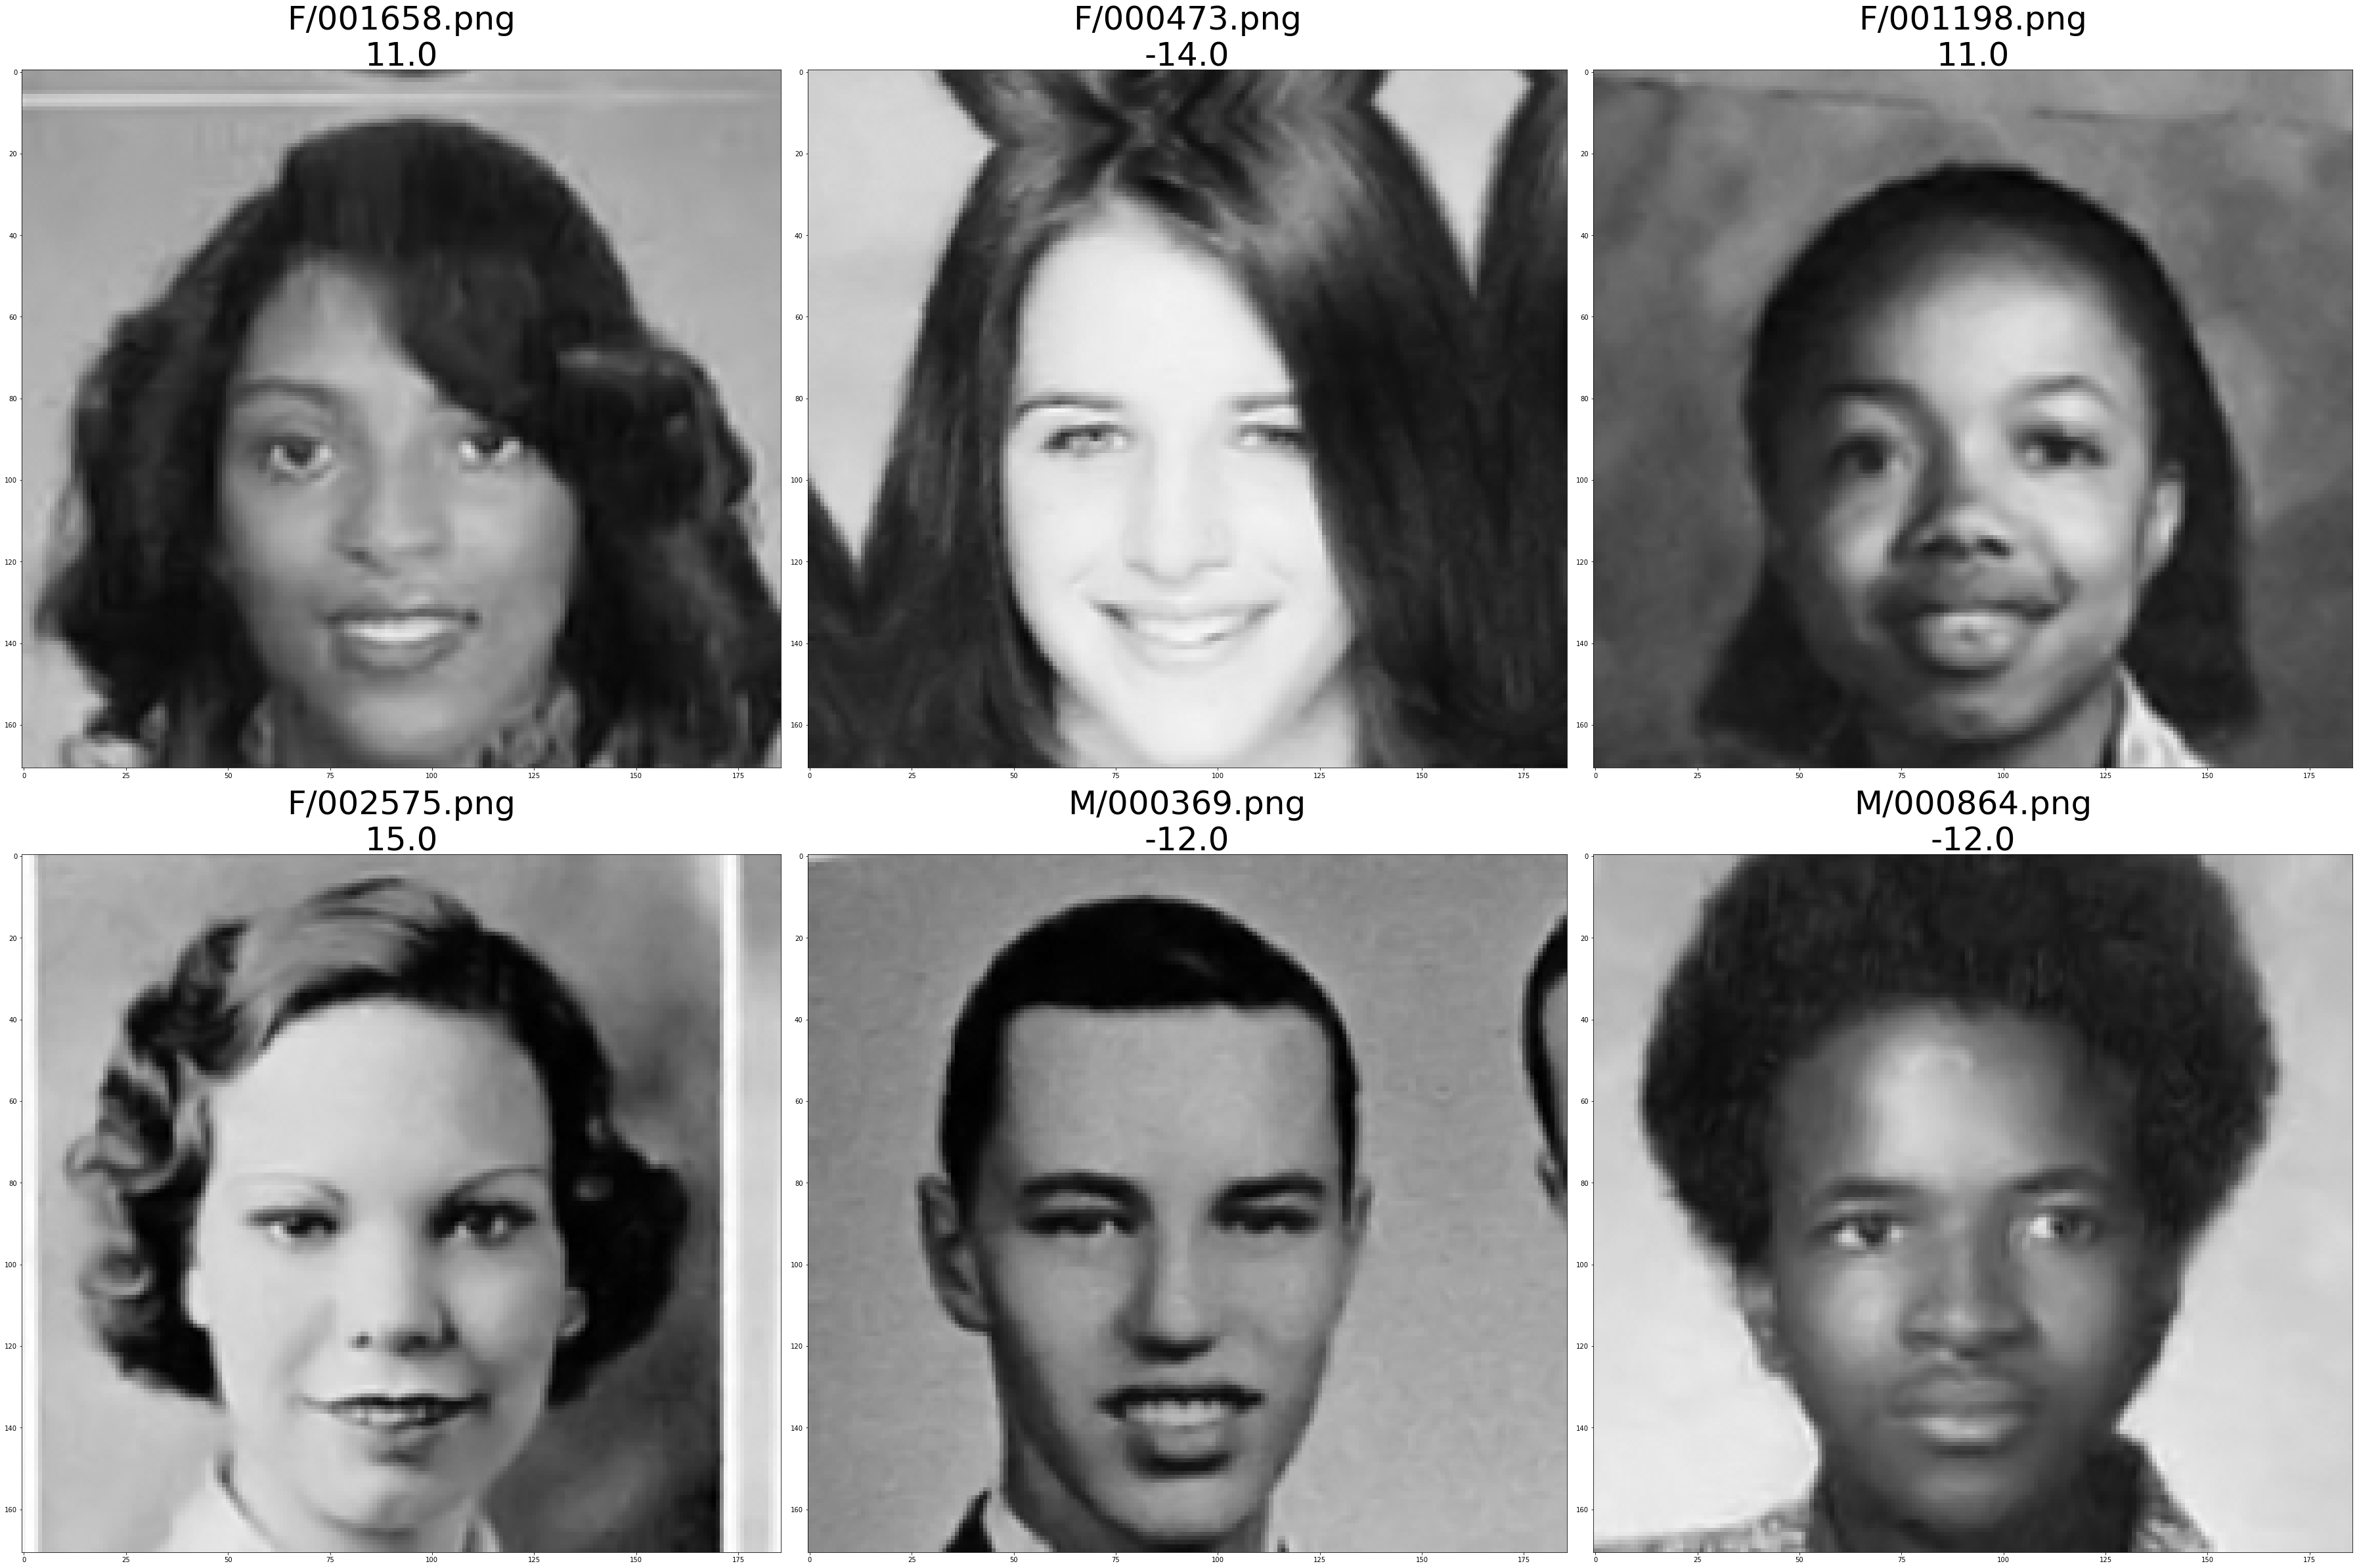

In [97]:
numImages = np.sum(differences > 10)
gridSize = int(math.ceil(math.sqrt(numImages)));
fig = plt.figure(figsize=(50, 50))
pltIdx = 1

mispred = y_pred[0] - batch_y['out_year']

for idx, diff in enumerate(differences):
    if diff > 10:
        fname = filenames[idx];
        img = load_img(
            os.path.join(data_path + 'valid', fname),
            grayscale = True,
            target_size = (171, 186, 3))
        y = np.stack((img, img, img), axis = -1)
        ax = fig.add_subplot(gridSize, gridSize, pltIdx)
        ax.title.set_text(fname + '\n' + str(mispred[idx]))
        ax.title.set_fontsize(50)
        plt.imshow(y)
        pltIdx += 1

plt.tight_layout()
        
plt.show()

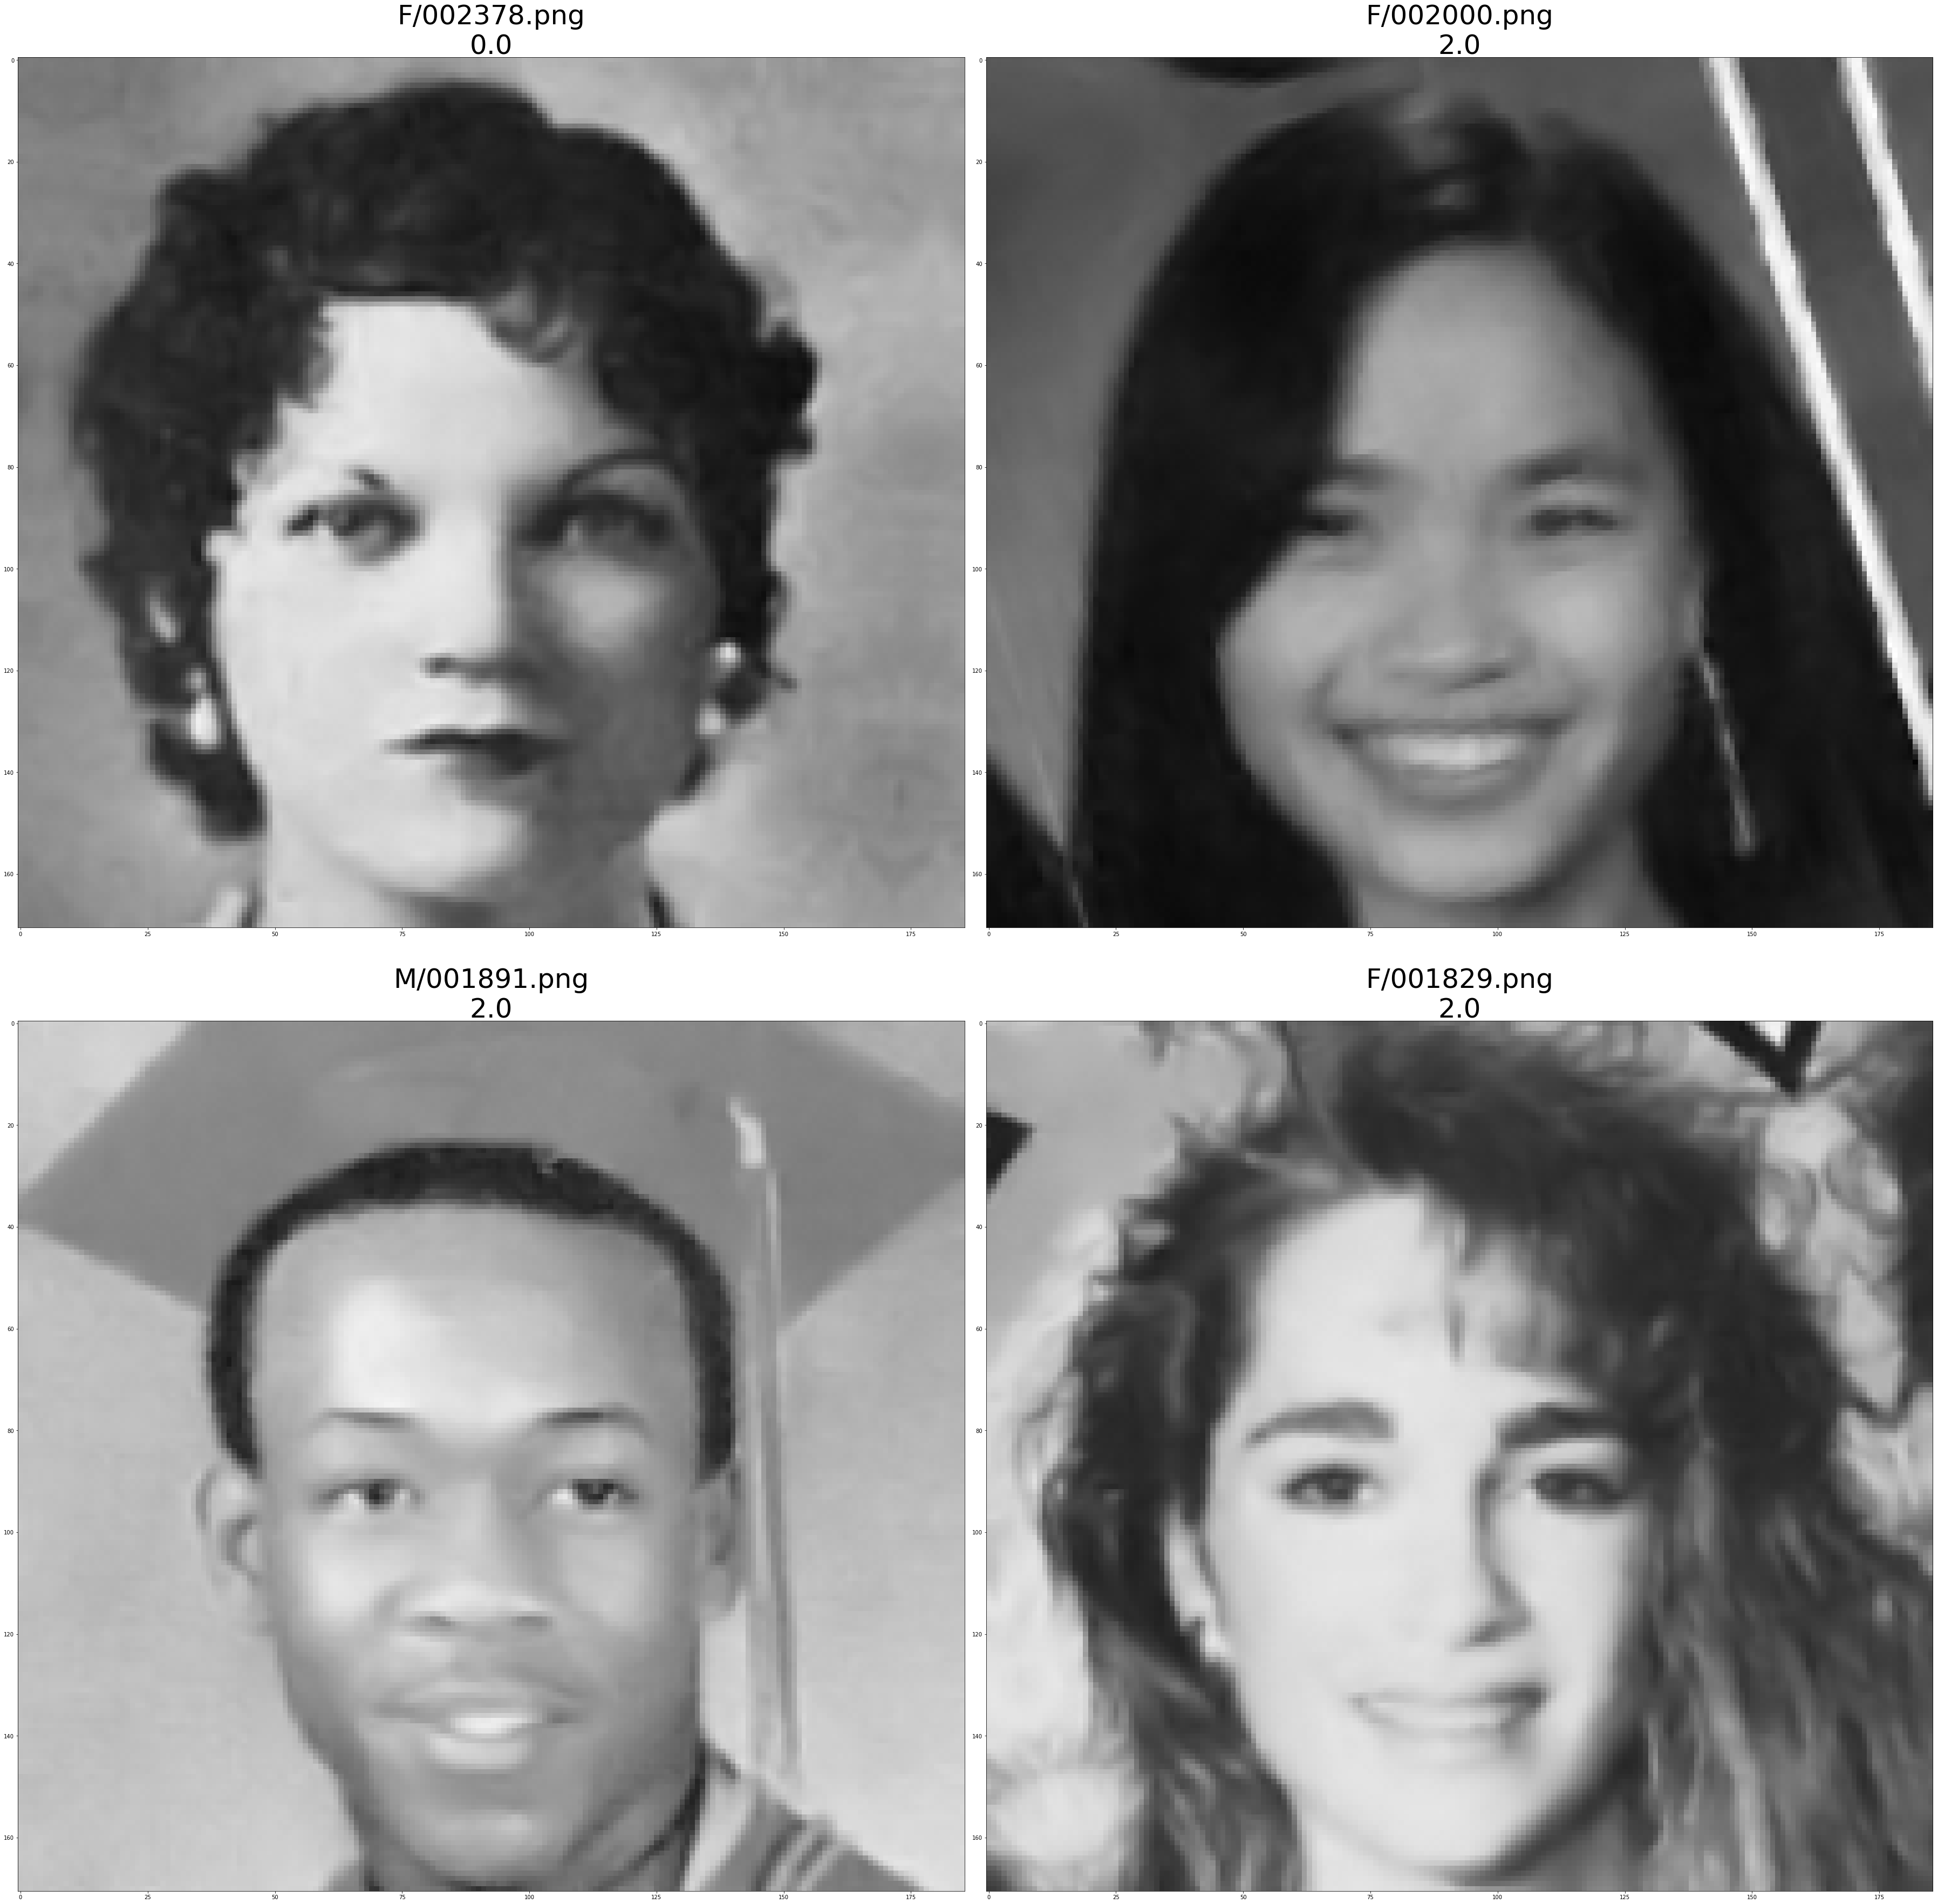

In [96]:
numImages = np.sum(differences < 3)
gridSize = int(math.ceil(math.sqrt(numImages)));
fig = plt.figure(figsize=(50, 50))
pltIdx = 1

mispred = y_pred[0] - batch_y['out_year']

for idx, diff in enumerate(differences):
    if diff < 3:
        fname = filenames[idx];
        img = load_img(
            os.path.join(data_path + 'valid', fname),
            grayscale = True,
            target_size = (171, 186, 3))
        y = np.stack((img, img, img), axis = -1)
        ax = fig.add_subplot(gridSize, gridSize, pltIdx)
        ax.title.set_text(fname + '\n' + str(mispred[idx]))
        ax.title.set_fontsize(50)
        plt.imshow(y)
        pltIdx += 1

plt.tight_layout()
        
plt.show()